# Imports

In [26]:
import pdb
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Input, Flatten, Conv2D, MaxPooling2D 

# Predicting the mean, standard deviation of 2D Gaussian

## Using Neural Nets

In [27]:
def predict(model):
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000, add_noise=True)
        
    # Apply the model to get predicted means and sigmas of the Gaussians
    pamp, pxmu, pxsig, pymu, pysig = model.predict(predX, batch_size=None, verbose=0)
    
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(511)
    _, _, _ = plt.hist(predy[:, 0] - pamp.flatten(), bins=30)
    plt.subplot(512)
    _, _, _ = plt.hist(predy[:, 1] - pxmu.flatten(), bins=30)
    plt.subplot(513)
    _, _, _ = plt.hist(predy[:, 2] - pxsig.flatten(), bins=30)
    plt.subplot(514)
    _, _, _ = plt.hist(predy[:, 3] - pymu.flatten(), bins=30)
    plt.subplot(515)
    _, _, _ = plt.hist(predy[:, 4] - pysig.flatten(), bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_amp = np.linspace(1., 10., 32) #one-to-one relation for amplitudes
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
    
    # Plot the true y's and predicted y's from the NN model
    ax1.scatter(predy[:, 0], pamp.flatten(), marker='.')
    # Plot the 1-to-1 line
    ax1.plot(oto_amp, oto_amp, color='black', ls='--')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title(r'Gaussian Amplitude')

    ax2.scatter(predy[:, 1], pxmu.flatten(), marker='.')
    ax2.plot(oto_means, oto_means, color='black', ls='--')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(r'Gaussian x-$\mu$')
    
    ax3.scatter(predy[:, 2], pxsig.flatten(), marker='.')
    ax3.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    ax3.set_xlabel('True value')
    ax3.set_ylabel('Predicted value')
    ax3.set_title(r'Gaussian x-$\sigma$')
    
    ax4.scatter(predy[:, 3], pymu.flatten(), marker='.')
    ax4.plot(oto_means, oto_means, color='black', ls='--')
    ax4.set_xlabel('True value')
    ax4.set_ylabel('Predicted value')
    ax4.set_title(r'Gaussian y-$\mu$')
    
    ax5.scatter(predy[:, 4], pysig.flatten(), marker='.')
    ax5.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    ax5.set_xlabel('True value')
    ax5.set_ylabel('Predicted value')
    ax5.set_title(r'Gaussian y-$\sigma$')

    fig.show()

In [28]:
def predict_v2(model):
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000, add_noise=True)
    
    # Apply the model to get predicted means and sigmas of the Gaussians
    pred_model = model.predict(predX, batch_size=None, verbose=0)
        
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(511)
    _, _, _ = plt.hist(predy[:,0] - pred_model[:,0], bins=30)
    plt.subplot(512)
    _, _, _ = plt.hist(predy[:,1] - pred_model[:,1], bins=30)
    plt.subplot(513)
    _, _, _ = plt.hist(predy[:,2] - pred_model[:,2], bins=30)
    plt.subplot(514)
    _, _, _ = plt.hist(predy[:,3] - pred_model[:,3], bins=30)
    plt.subplot(515)
    _, _, _ = plt.hist(predy[:,4] - pred_model[:,4], bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_amp = np.linspace(1., 10., 32) #one-to-one relation for amplitudes
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
    
    # Plot the true y's and predicted y's from the NN model
    ax1.scatter(predy[:,0], pred_model[:,0], marker='.')
    # Plot the 1-to-1 line
    ax1.plot(oto_amp, oto_amp, color='black', ls='--')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title(r'Gaussian Amplitude')

    ax2.scatter(predy[:,1], pred_model[:,1], marker='.')
    ax2.plot(oto_means, oto_means, color='black', ls='--')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(r'Gaussian x-$\mu$')
    
    ax3.scatter(predy[:,2], pred_model[:,2], marker='.')
    ax3.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    ax3.set_xlabel('True value')
    ax3.set_ylabel('Predicted value')
    ax3.set_title(r'Gaussian x-$\sigma$')
    
    ax4.scatter(predy[:,3], pred_model[:,3], marker='.')
    ax4.plot(oto_means, oto_means, color='black', ls='--')
    ax4.set_xlabel('True value')
    ax4.set_ylabel('Predicted value')
    ax4.set_title(r'Gaussian y-$\mu$')
    
    ax5.scatter(predy[:,4], pred_model[:,4], marker='.')
    ax5.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    ax5.set_xlabel('True value')
    ax5.set_ylabel('Predicted value')
    ax5.set_title(r'Gaussian y-$\sigma$')

    fig.show()

### Generate Gaussian given mu, sigma

In [50]:
# Calculate a 2d Gaussian given its mean and standard deviation
def gaussian2d(x_vals, y_vals, amp, x_mu, x_sigma, y_mu, y_sigma):
    return amp * np.exp(-0.5 * ( ((x_vals - x_mu)/x_sigma)**2 + ((y_vals - y_mu)/y_sigma)**2 ))

# Make array that describes Gaussian
def make_gaussians(num, amp_min=1., amp_max = 10.0, mu_min=-1.0, mu_max=1.0, sig_min=0.25, sig_max=4.0, add_noise=False): 

    amp = np.random.uniform(amp_min, amp_max, num)
    
    x_mus = np.random.uniform(mu_min, mu_max, num)
    x_sigmas = np.random.uniform(sig_min, sig_max, num)
    
    y_mus = np.random.uniform(mu_min, mu_max, num)
    y_sigmas = np.random.uniform(sig_min, sig_max, num)

    x_vals = np.linspace(-10.0, 10.0, 32)
    y_vals = np.linspace(-10.0, 10.0, 32)
    
    x_grid, y_grid = np.meshgrid(x_vals, y_vals)
    
    models = np.zeros((num, 32, 32))
    noise = np.zeros((num, 32, 32))
    noise_stds = np.random.uniform(0.0, sig_max, num)
    
    #if add_noise:
        # Add some noise -- currently noise is Gaussian but all with same standard deviation = 1.0
    #    noise = np.random.normal(0.0, 1.0, models.shape)

    for i in range(num):
        models[i] = gaussian2d(x_grid, y_grid, amp[i], x_mus[i], x_sigmas[i], y_mus[i], y_sigmas[i])
        
        if add_noise:
            noise[i] = np.random.normal(0.0, noise_stds[i], models[0].shape)
    
    # Also want to save and return the true means, sigmas used for the Gaussians
    targets = np.vstack((amp, x_mus, x_sigmas, y_mus, y_sigmas)).T
    
    models = models.reshape(num, 32, 32, 1)
    noise = noise.reshape(num, 32, 32, 1)

    return models+noise, targets

In [51]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000):
    X_train, y_train = make_gaussians(n_train, add_noise=True)
    X_test, y_test = make_gaussians(n_test, add_noise=True)
    
    #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
    return X_train, y_train, X_test, y_test

### Create, compile, fit, and evaluate NN model

In [31]:
# Check out: https://datascience.stackexchange.com/questions/28003/get-multiple-output-from-keras
# for multi-output regression using Keras NNs

def evaluate_model(X_train, y_train, X_test, y_test):
    # Create model
    # Here, this means that our training set of 10000 samples will be divided into
    # 10000/batch_size = 10000/16 = 625 batches, each with 16 samples. The model
    # weights will be updated after each batch of 16. One epoch will involve 625 batches.
    verbose, epochs, batch_size = 1, 100, 16

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])) # this returns the 32x32 2d array of Gaussian

    x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
    x = Conv2D(filters=8, kernel_size=(2,2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)    
    
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    
    out1 = Dense(1, activation='linear', name='amplitude')(x)
    out2 = Dense(1, activation='linear', name='x_mean')(x)
    out3 = Dense(1, activation='linear', name='x_sigma')(x)
    out4 = Dense(1, activation='linear', name='y_mean')(x)
    out5 = Dense(1, activation='linear', name='y_sigma')(x)

    # Create model with input layer and dense layers
    model = Model(inputs=inputs, outputs=[out1, out2, out3, out4, out5])
    model.summary()
    model.compile(loss='mse', optimizer='rmsprop')

    # Fit model
    model.fit(X_train, [y_train[:,0], y_train[:,1], y_train[:,2], y_train[:,3], y_train[:,4]], 
              epochs=epochs, verbose=verbose)
    
    # Run model on test set
    loss = model.evaluate(X_test, [y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3], y_test[:,4]], 
                          batch_size=batch_size, verbose=0)
    
    predict(model)
    
    return loss

In [52]:
def evaluate_model_v2(X_train, y_train, X_test, y_test):
    # Create model
    verbose, epochs, batch_size = 1, 100, 16

    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8, kernel_size=(2,2), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(8))
    model.add(Activation('relu'))
    model.add(Dense(5))
    model.add(Activation('linear'))

    # Create model with input layer and dense layers
    model.summary()
    model.compile(loss='mse', optimizer='rmsprop')

    # Fit model
    model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
    
    # Run model on test set
    loss = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    
    #predict(model)
    predict_v3(model)
    
    return loss

In [33]:
# If relevant, check accuracy of the model
def summarize_results(scores):
    #print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
    return

In [53]:
def detect_features(repeats=1):
    # Generate data
    X_train, y_train, X_test, y_test = generate_dataset()
    
    # Repeat experiment
    scores = list()
    
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        # **** score[0] below is currently the loss
        score = np.asarray(score[0]) * 100.0
        print('>#%d: %.3f' % (r + 1, score))
        scores.append(score)
        
    # Summarize results
    #summarize_results(scores)
    
    return

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 30, 30, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 29, 29, 8)    520         conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 8)    0           conv2d_12[0][0]                  
____________________________________________________________________________________________

10000/10000 [==============================] - 5s 471us/step - loss: 0.3126 - amplitude_loss: 0.1462 - x_mean_loss: 0.0339 - x_sigma_loss: 0.0507 - y_mean_loss: 0.0313 - y_sigma_loss: 0.0505
Epoch 29/100
10000/10000 [==============================] - 5s 532us/step - loss: 0.2944 - amplitude_loss: 0.1355 - x_mean_loss: 0.0324 - x_sigma_loss: 0.0468 - y_mean_loss: 0.0308 - y_sigma_loss: 0.0488
Epoch 30/100
10000/10000 [==============================] - 6s 598us/step - loss: 0.2866 - amplitude_loss: 0.1341 - x_mean_loss: 0.0317 - x_sigma_loss: 0.0451 - y_mean_loss: 0.0290 - y_sigma_loss: 0.0467
Epoch 31/100
10000/10000 [==============================] - 6s 604us/step - loss: 0.2823 - amplitude_loss: 0.1353 - x_mean_loss: 0.0308 - x_sigma_loss: 0.0437 - y_mean_loss: 0.0285 - y_sigma_loss: 0.0442
Epoch 32/100
10000/10000 [==============================] - 5s 502us/step - loss: 0.2757 - amplitude_loss: 0.1312 - x_mean_loss: 0.0297 - x_sigma_loss: 0.0430 - y_mean_loss: 0.0278 - y_sigma_loss: 

10000/10000 [==============================] - 5s 500us/step - loss: 0.1494 - amplitude_loss: 0.0777 - x_mean_loss: 0.0144 - x_sigma_loss: 0.0219 - y_mean_loss: 0.0141 - y_sigma_loss: 0.0213
Epoch 69/100
10000/10000 [==============================] - 5s 506us/step - loss: 0.1477 - amplitude_loss: 0.0752 - x_mean_loss: 0.0144 - x_sigma_loss: 0.0215 - y_mean_loss: 0.0142 - y_sigma_loss: 0.0224
Epoch 70/100
10000/10000 [==============================] - 5s 503us/step - loss: 0.1445 - amplitude_loss: 0.0733 - x_mean_loss: 0.0144 - x_sigma_loss: 0.0214 - y_mean_loss: 0.0138 - y_sigma_loss: 0.0216
Epoch 71/100
10000/10000 [==============================] - 5s 483us/step - loss: 0.1425 - amplitude_loss: 0.0731 - x_mean_loss: 0.0145 - x_sigma_loss: 0.0209 - y_mean_loss: 0.0134 - y_sigma_loss: 0.0206
Epoch 72/100
10000/10000 [==============================] - 5s 497us/step - loss: 0.1418 - amplitude_loss: 0.0715 - x_mean_loss: 0.0140 - x_sigma_loss: 0.0213 - y_mean_loss: 0.0138 - y_sigma_loss: 

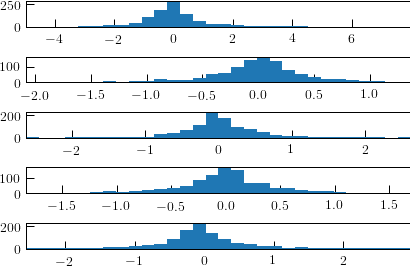

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


>#1: 244.225


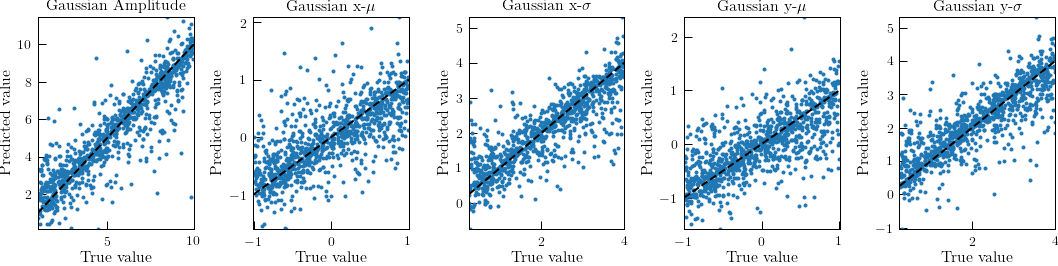

In [54]:
detect_features()


# Plot 2D Gaussian

In [ ]:
# Import for 3d plotting
from mpl_toolkits import mplot3d

In [ ]:
# Create x, y grid, and use it to generate a 2d Gaussian
x_vals = np.linspace(-10, 10, 32)
y_vals = np.linspace(-10, 10, 32)

x, y = np.meshgrid(x_vals, y_vals)

z = gaussian2d(x, y, 1, 0, 2, 0, 2)

# Plot 2d Gaussian
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, rstride=1, cstride=2, cmap='winter')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()